# Pricing Model Selection

### Using one dataset to learn and predict on the other

# DRAFT - UNFINISHED

### Client request
Here is an excel file with 2 data sets. This is actual data.

The first data set is a standard correlation where the baseline and benchmark show a strong correlation according to my simple method
The second data set is an example where the correlation is good, until it is not for a period of 12 months or so, before the lines come back together. This was caused by a disruption by a fire at one supplier after which capacity was limited and the link between market pricing and cost driver pricing was no longer relevant

Some notes <br>
The 2 data sets which I am running my analysis on are shaded in blue. 
I have added the formulas so you can see how they are calculated from the underlying data sets. 
Some of the data preparation (averaging, adjusting for lag, FX conversion) is not visible in this file but it is not so relevant for the statistics.

__I would love to know if there is a better way to:__
- Understand or analyse the correlation between the 2 main lines
- Understand the correlation between the base line and each of the individual cost drivers so that the cost drivers could be ranked in terms of relevance in some way

I am available to answer any questions about this data. 

#### Read in necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from jmspack.utils import (apply_scaling,
                          JmsColors)
from jmspack.ml_utils import plot_confusion_matrix, plot_learning_curve, dict_of_models
from jmspack.frequentist_statistics import correlation_analysis

# from dtw import *
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import shap

/Users/james/miniconda3/envs/ds_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
shap.initjs()

#### Set plotting style

In [3]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

#### Read in data frames

In [4]:
df_train = (pd.read_excel("data/Input for statistics v1.xlsx", sheet_name=0)
    .assign(**{"Date": lambda x: pd.to_datetime(x["Date"]).dt.date})
    .dropna()
    .set_index("Date")
)
df_test = (pd.read_excel("data/Input for statistics v1.xlsx", sheet_name=1)
    .assign(**{"Date": lambda x: pd.to_datetime(x["Date"]).dt.date})
    .dropna()
    .set_index("Date")
    )

#### Show the head of the data frame

In [5]:
df_train.head(); df_test.head()

,Baseline,Weighted benchmark,Benchmark index,Chlorine,Benzene,Aluminium
Date,,,,,,
2017-04-01,1.068,1.06685,1.121545,1.099,1.013,1.239
2017-05-01,1.087,1.07005,1.127364,1.099,1.006,1.265
2017-06-01,1.087,1.07815,1.142091,1.099,1.087,1.265
2017-07-01,1.087,1.07765,1.141182,1.093,1.142,1.237
2017-08-01,1.087,1.07565,1.137545,1.069,1.188,1.241


#### Define the target and display simple summary statistics of the columns

In [6]:
target = "Baseline"

In [7]:
display(df_train.describe()); df_test.describe()

,Baseline,Weighted benchmark,Benchmark index,EHA,Acrylic Acid,Styrene
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,1.012518,0.999170,0.998616,1.139804,1.123946,0.865357
std,0.099634,0.113010,0.188350,0.264228,0.219361,0.183202
min,0.862000,0.825250,0.708750,0.846000,0.846000,0.499000
25%,0.944750,0.937937,0.896562,0.935000,0.983750,0.770250
50%,1.002500,0.980200,0.967000,1.030500,1.064000,0.933500
75%,1.056250,1.055350,1.092250,1.360500,1.174500,1.003000
max,1.176000,1.208800,1.348000,1.664000,1.624000,1.193000


,Baseline,Weighted benchmark,Benchmark index,Chlorine,Benzene,Aluminium
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,1.070700,1.032053,1.058279,1.031233,1.062683,1.109433
std,0.043434,0.038837,0.070612,0.084605,0.093602,0.102285
min,0.997000,0.952650,0.913909,0.894000,0.787000,0.863000
25%,1.039250,1.006787,1.012341,0.985000,1.004500,1.037500
50%,1.066500,1.038575,1.070136,1.029000,1.088500,1.135500
75%,1.087000,1.050563,1.091932,1.064000,1.121750,1.194000
max,1.160000,1.143200,1.260364,1.371000,1.216000,1.265000


### Plot the amount of rows in the target

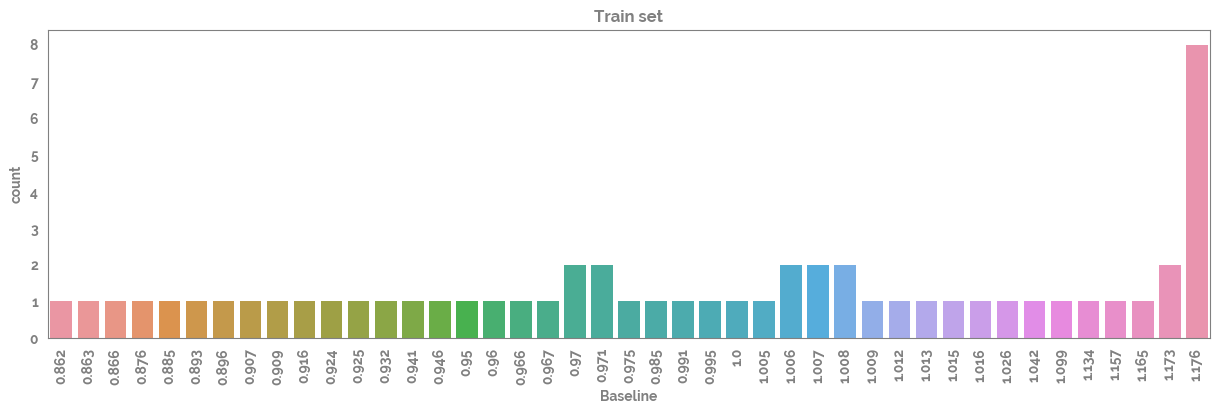

In [8]:
_ = plt.figure(figsize=(15, 4))
_ = sns.countplot(x=df_train[target])
_ = plt.xticks(rotation=90)
_ = plt.title("Train set")

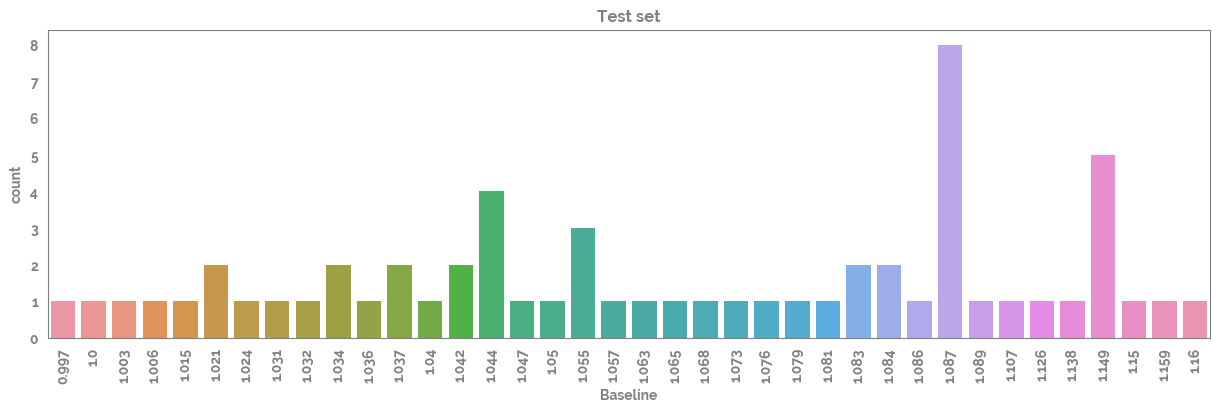

In [9]:
_ = plt.figure(figsize=(15, 4))
_ = sns.countplot(x=df_test[target])
_ = plt.xticks(rotation=90)
_ = plt.title("Test set")

### Plot the heatmaps of the raw and scaled data

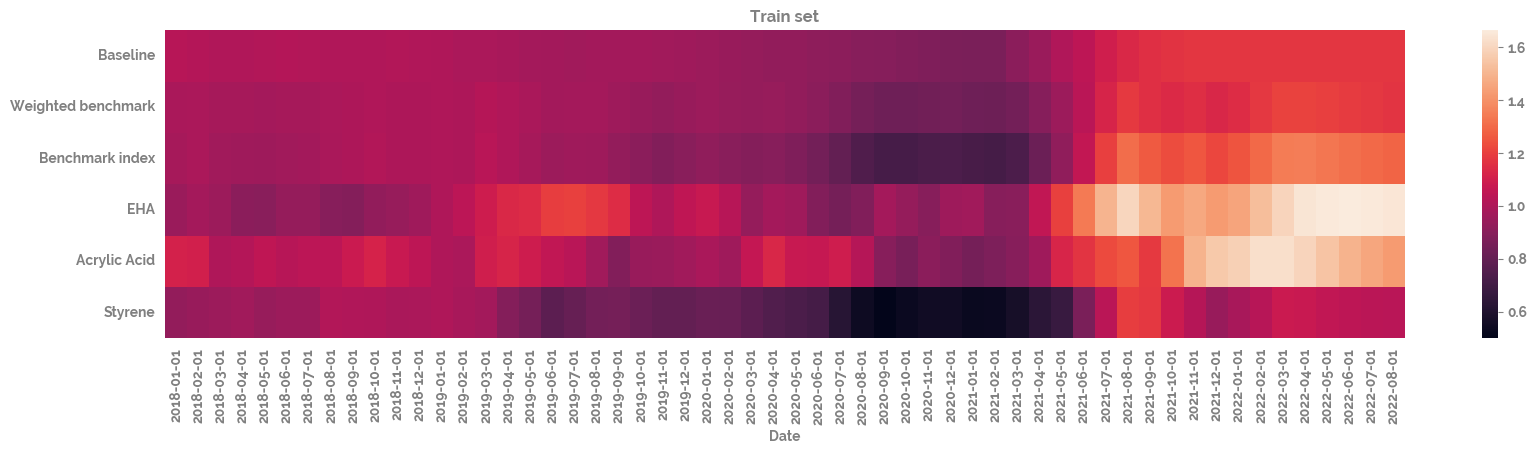

In [10]:
_ = plt.figure(figsize=(20, 4))
_ = sns.heatmap(df_train
                # .drop(target, axis=1)
                .T
)
_ = plt.title("Train set")

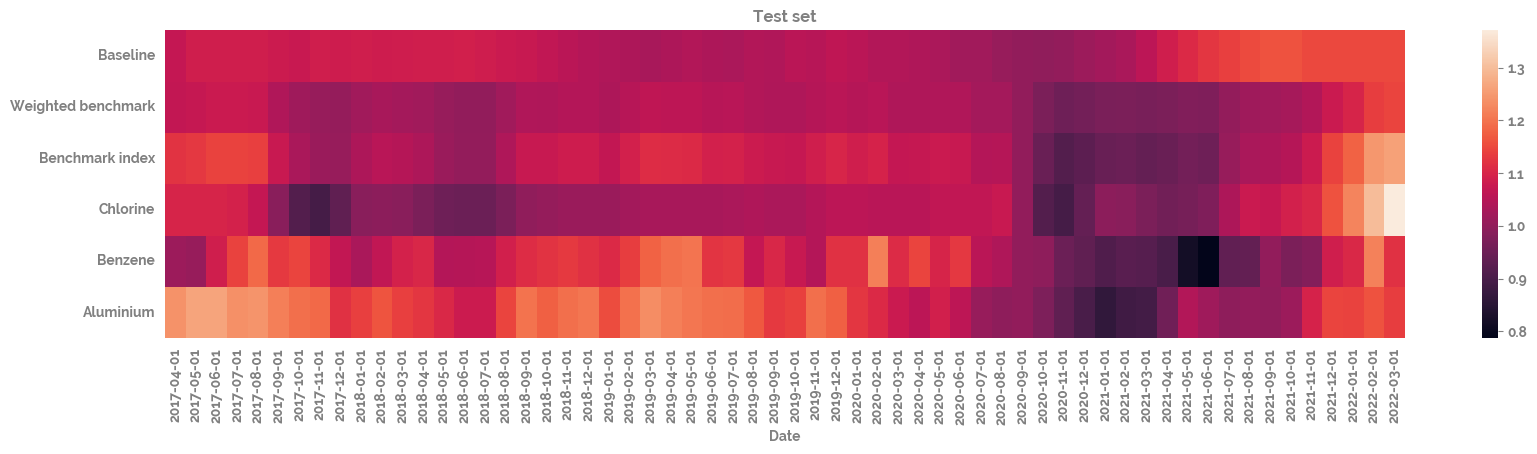

In [11]:
_ = plt.figure(figsize=(20, 4))
_ = sns.heatmap(df_test
                # .drop(target, axis=1)
                .T
)
_ = plt.title("Test set")

### Plot the correlation of all of the different time series with each other

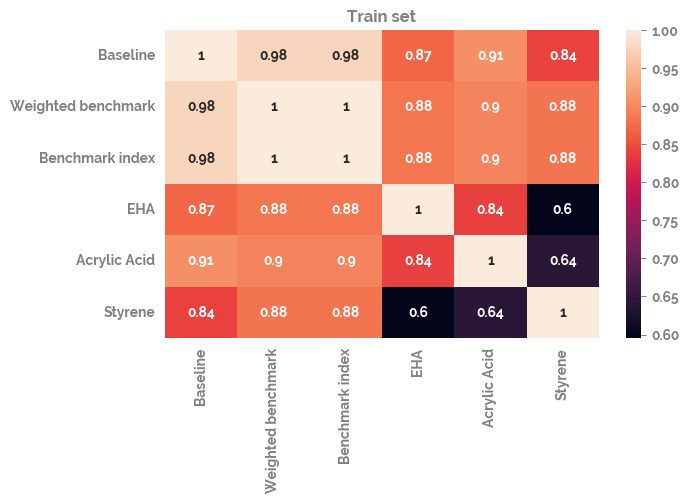

In [12]:
_ = plt.figure(figsize=(7, 4))
_ = sns.heatmap(df_train.corr(), annot=True)
_ = plt.title("Train set")

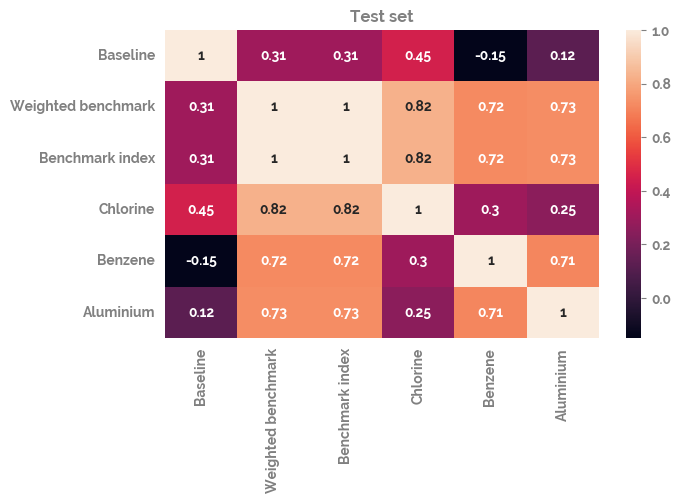

In [13]:
_ = plt.figure(figsize=(7, 4))
_ = sns.heatmap(df_test.corr(), annot=True)
_ = plt.title("Test set")

### Plot all of the features over time

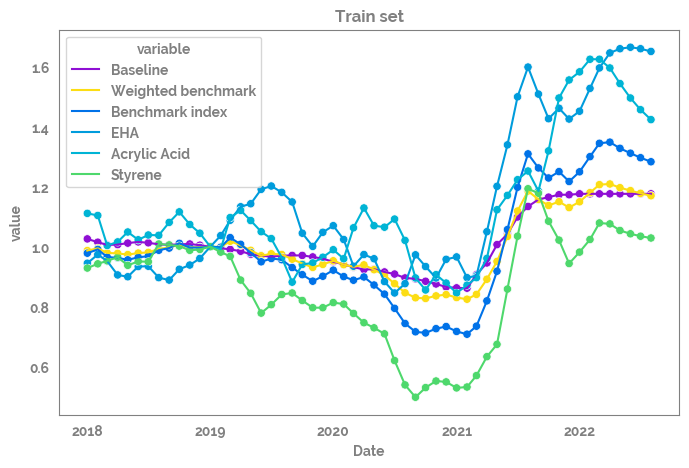

In [14]:
_ = plt.figure(figsize=(8, 5))
_ = sns.lineplot(data=df_train
                .reset_index()
                .melt(id_vars="Date"),
                x="Date",
                y="value",
                hue="variable"
                )

_ = sns.scatterplot(data=df_train
                .reset_index()
                .melt(id_vars="Date"),
                x="Date",
                y="value",
                hue="variable",
                legend=False
                )
_ = plt.title("Train set")

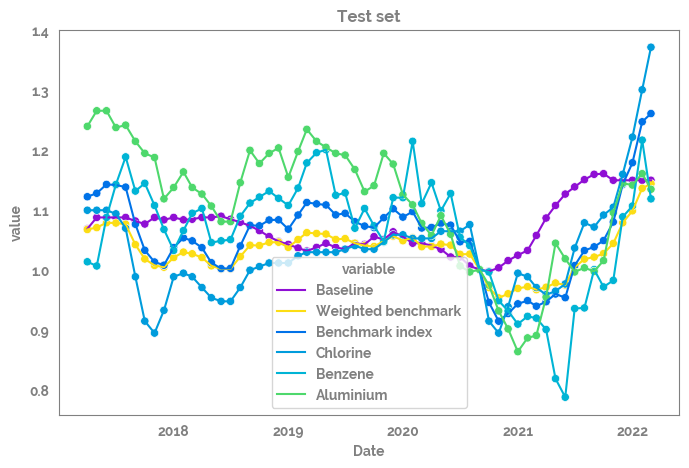

In [15]:
_ = plt.figure(figsize=(8, 5))
_ = sns.lineplot(data=df_test
                .reset_index()
                .melt(id_vars="Date"),
                x="Date",
                y="value",
                hue="variable"
                )

_ = sns.scatterplot(data=df_test
                .reset_index()
                .melt(id_vars="Date"),
                x="Date",
                y="value",
                hue="variable",
                legend=False
                )
_ = plt.title("Test set")

## Run a regression

##### Split the data frame to predictors data frame and target series

In [16]:
X = df_train.drop(target,axis=1)
y = df_train[target]

X.shape, y.shape

((56, 5), (56,))

##### Define the model

In [17]:
mod = RandomForestRegressor(random_state=42)
# mod = LinearRegression(fit_intercept=True)

##### Fit the model to the whole data set and "predict" the target (there is no train test or cross-validation here)

In [18]:
_ = mod.fit(X, y)
y_pred = mod.predict(X)
df_test = pd.DataFrame({"y_pred": y_pred, target: y})

##### Use SHAP values to show feature importance in the model 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


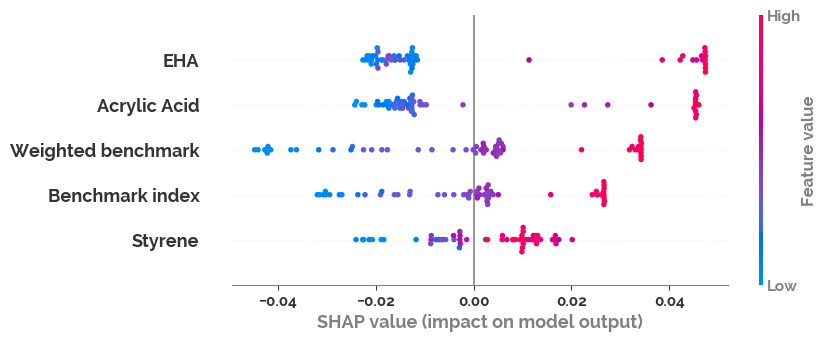

In [19]:
if mod.__class__.__name__ != "LinearRegression":
    explainer = shap.Explainer(mod)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values)

##### Use gini importance values to show feature importance in the model 

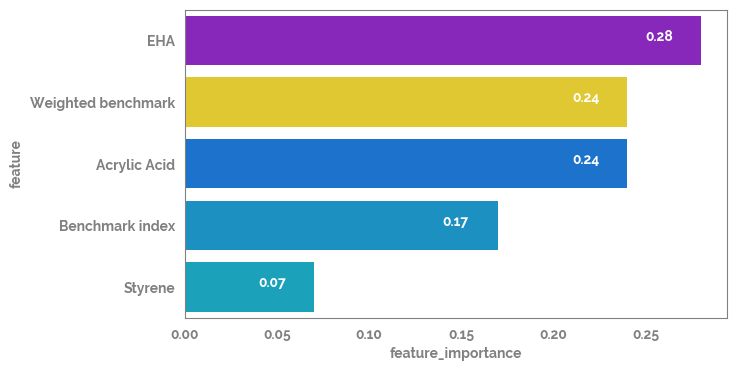

In [20]:
feature_importance = pd.Series(dict(zip(X.columns, mod.feature_importances_.round(2)))) 
feature_importance_df = pd.DataFrame(feature_importance.sort_values(ascending=False)).reset_index().rename(columns={"index": "feature", 0: "feature_importance"})
_ = plt.figure(figsize=(7, 4))
_ = sns.barplot(data=feature_importance_df, x="feature_importance", y="feature")
for i in feature_importance_df.index:
    _ = plt.text(x=feature_importance_df.loc[i, "feature_importance"]-0.03, 
                y=i, 
                s=feature_importance_df.loc[i, "feature_importance"],
                color="white")

##### Show the correlation of the fitted vs the real target

In [21]:
dict_results = correlation_analysis(data=df_test, 
                     col_list=["y_pred"], 
                     row_list=[target], 
                     check_norm=True, 
                     method = 'pearson', 
                     dropna = 'pairwise')
cors_df=dict_results["summary"]

r_value = cors_df["r-value"].values[0].round(3)
p_value = cors_df["p-value"].values[0].round(3)
if p_value < 0.001:
    p_value = "< 0.001"
n = cors_df["N"].values[0].round(3)

cors_df

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,analysis,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman Rank,y_pred,Baseline,0.993958,1.658809e-53,True,56


##### Plot the linear relationship between the fitted vs the real target

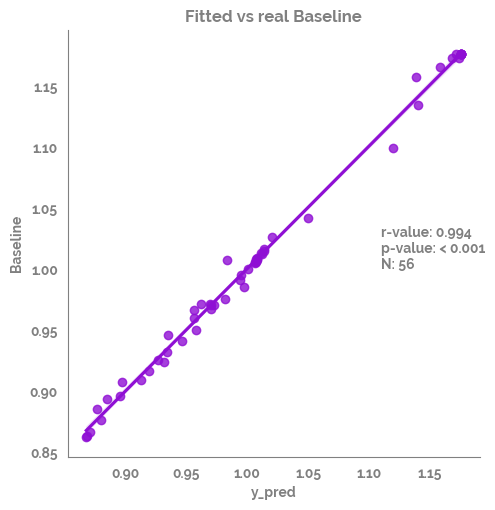

In [22]:
_ = sns.lmplot(data=df_test,
               x="y_pred",
               y=target)
_ = plt.annotate(text=f"r-value: {r_value}\np-value: {p_value}\nN: {n}", xy=(1.11,1))
_ = plt.title(f"Fitted vs real {target}")

In [23]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

##### Plot the learning curve of the model - seems like it is not converging - likely it is overfitting (also sample size is small)

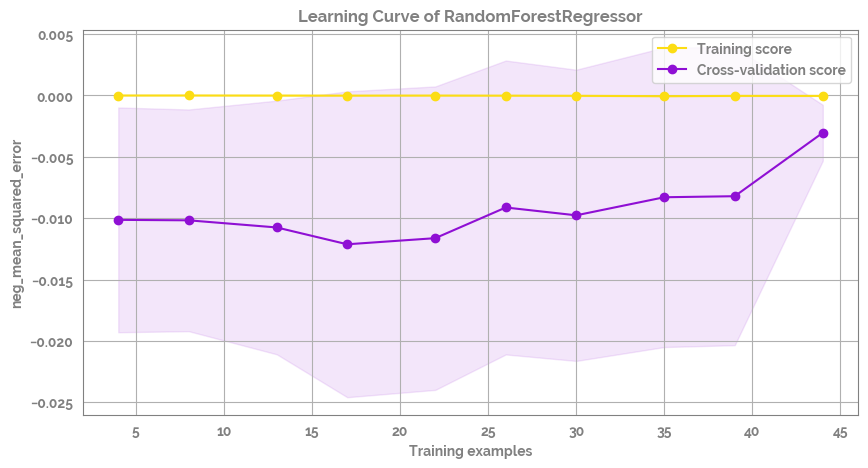

In [24]:
fig = plot_learning_curve(estimator=mod, 
                          title=f'Learning Curve of {mod.__class__.__name__}',
                          X=X, 
                          y=y,
                          groups=None, 
                          cross_color=JmsColors.PURPLE, 
                          test_color=JmsColors.YELLOW, 
                          scoring='neg_mean_squared_error', #'r2'
                          ylim=None, 
                          cv=None, 
                          n_jobs=10, 
                          train_sizes=np.linspace(.1, 1.0, 10), 
                          figsize=(10,5))

##### Run some cross validations (fit in train, predict in test)
Plot the difference between real and precited and the correlation between real and predicted

Redefine X to just use the top feature (in an attempt to stop overfitting)

In [25]:
X = df_train[[feature_importance_df.loc[0, "feature"]]]

The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.


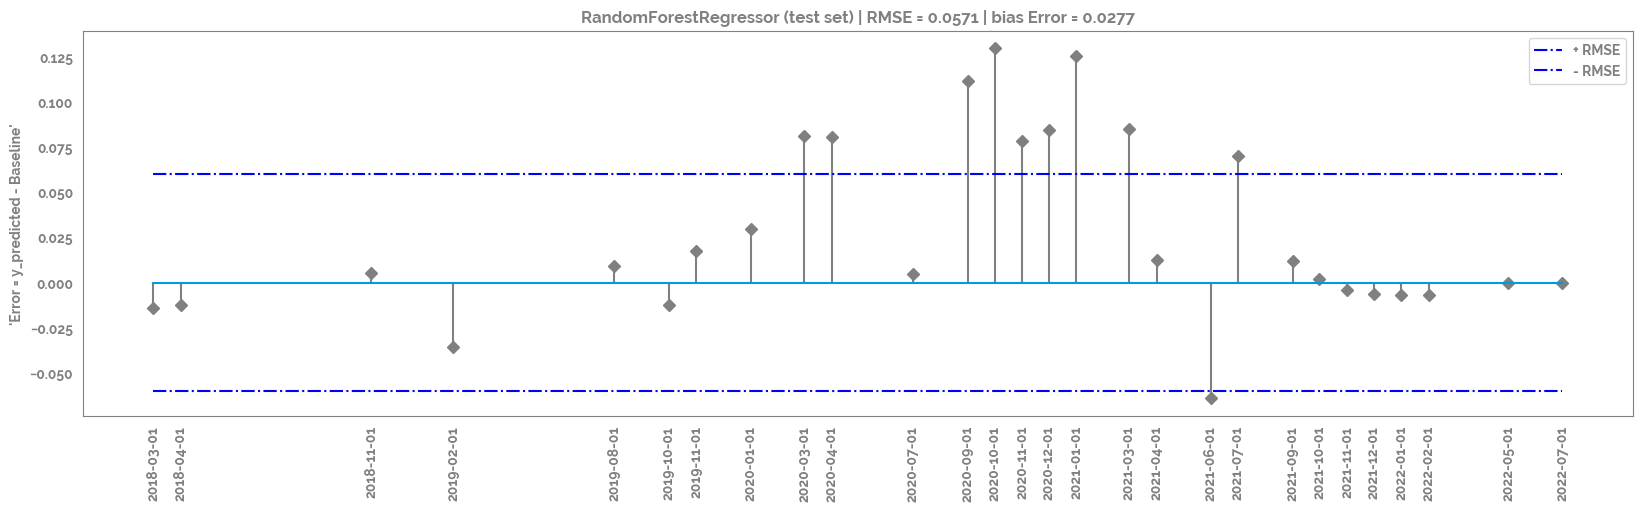

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,analysis,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman Rank,y_pred,Baseline,0.698887,0.000035,True,28


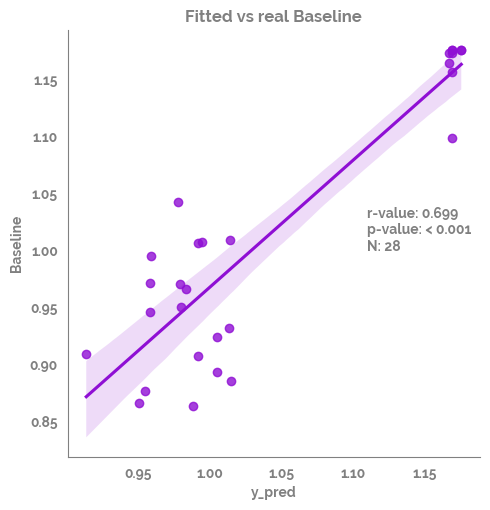

The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.


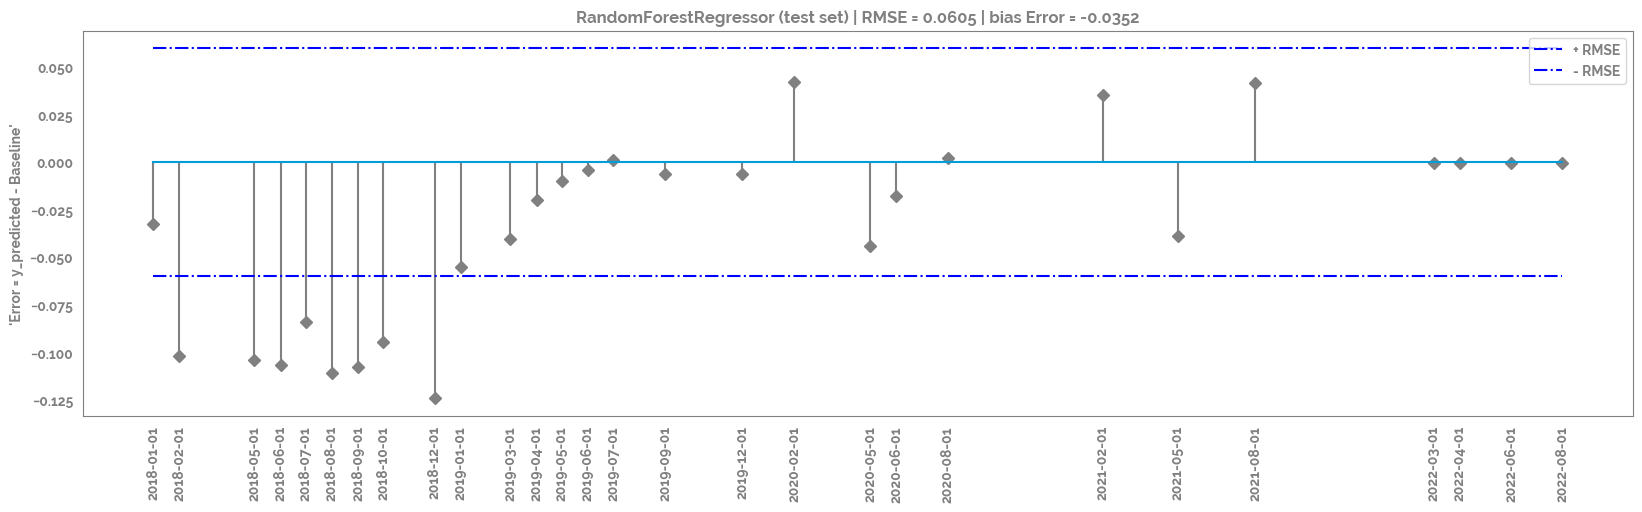

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,analysis,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman Rank,y_pred,Baseline,0.493671,0.007591,True,28


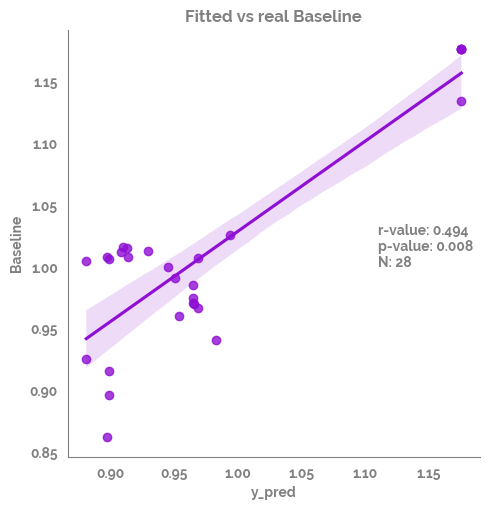

In [26]:
kfold = KFold(n_splits=2, shuffle=True, random_state=1)
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.iloc[train_ix, :], X.iloc[test_ix, :]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
    
    _ = mod.fit(X = train_X, 
                y = train_y)
    
    y_pred = mod.predict(test_X)

    df_test = pd.DataFrame({"y_pred": y_pred, target: test_y})

    user_ids_first = df_test.head(1).index.tolist()[0]
    user_ids_last = df_test.tail(1).index.tolist()[0]

    _ = plt.figure(figsize=(20,5))
    _ = plt.title(f"{mod.__class__.__name__} (test set) | RMSE = {round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),4)} | bias Error = {round(np.mean(df_test['y_pred'] - df_test[target]), 4)}")
    rmse_plot = plt.stem(df_test.index, df_test['y_pred'] - df_test[target], use_line_collection=True, linefmt='grey', markerfmt='D')
    _ = plt.hlines(y=round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2), colors='b', linestyles='-.', label='+ RMSE', 
                    xmin = user_ids_first, 
                    xmax = user_ids_last
                    ) 
    _ = plt.hlines(y=round(-np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2), colors='b', linestyles='-.', label='- RMSE', 
                    xmin = user_ids_first, 
                    xmax = user_ids_last
                    ) 
    _ = plt.xticks(rotation=90, ticks=df_test.index)
    _ = plt.ylabel(f"'Error = y_predicted - {target}'")
    _ = plt.legend()
    _ = plt.show()

    dict_results = correlation_analysis(data=df_test, 
                     col_list=["y_pred"], 
                     row_list=[target], 
                     check_norm=True, 
                     method = 'pearson', 
                     dropna = 'pairwise')
    cors_df=dict_results["summary"]

    r_value = cors_df["r-value"].values[0].round(3)
    p_value = cors_df["p-value"].values[0].round(3)
    if p_value < 0.001:
        p_value = "< 0.001"
    n = cors_df["N"].values[0].round(3)

    display(cors_df)

    _ = sns.lmplot(data=df_test,
               x="y_pred",
               y=target)
    _ = plt.annotate(text=f"r-value: {r_value}\np-value: {p_value}\nN: {n}", xy=(1.11,1))
    _ = plt.title(f"Fitted vs real {target}")
    _ = plt.show()

##### Plot the learning curve of the model - it is a bit better than before but still likely overfitting

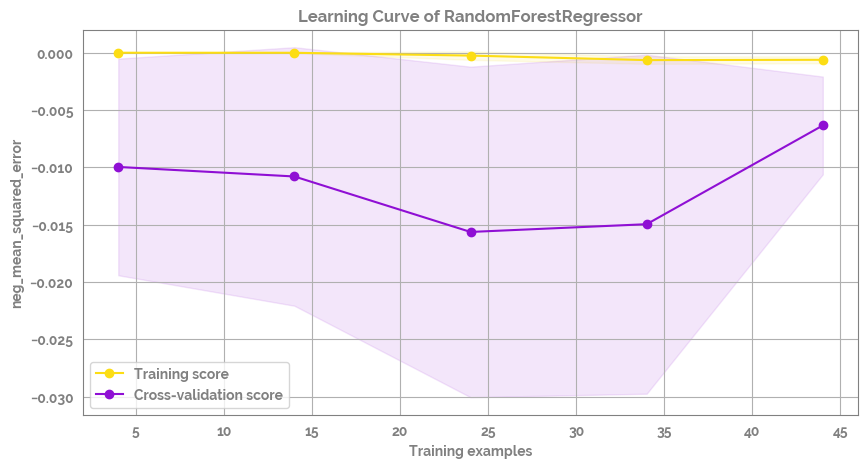

In [27]:
fig = plot_learning_curve(estimator=mod, 
                          title=f'Learning Curve of {mod.__class__.__name__}',
                          X=X, 
                          y=y,
                          groups=None, 
                          cross_color=JmsColors.PURPLE, 
                          test_color=JmsColors.YELLOW, 
                          scoring='neg_mean_squared_error', #'r2'
                          ylim=None, 
                          cv=None, 
                          n_jobs=10, 
                          train_sizes=np.linspace(.1, 1.0, 5), 
                          figsize=(10,5))